In [2]:
import os
import pandas as pd
import numpy as np
import anndata
from scipy.stats import zscore
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Arial"
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
import scanpy as sc

import re

from pyInfinityFlow.InfinityFlow_Utilities import marker_finder
from pyInfinityFlow.InfinityFlow_Utilities import pearson_corr_df_to_df


os.chdir("/media/kyle_storage/kyle_ferchen/grimes_lab_main/analysis/"\
    "2023_06_12_tea_seq_atac_processing/")

In [3]:
new_cluster_order = pd.read_csv("/media/kyle_storage/kyle_ferchen/"\
    "grimes_lab_main/data/2021_11_mouse_optimized_cite_seq/processed_files/"\
    "r7_cluster_order_kf_2024_01.csv")
map_r7_to_lv3 = pd.Series(\
    new_cluster_order["Level 3"].values,
    index=new_cluster_order["Cluster"].values)
map_lvl3_to_order = pd.Series(\
    new_cluster_order["Order"].values,
    index=new_cluster_order["Level 3"].values)
map_r7_to_replace_dash = pd.Series(\
    new_cluster_order["Cluster"].values,
    index=[i.replace("-", "_") for i in new_cluster_order["Cluster"].values])
new_cluster_order

,Cluster,Group,Old_order,CITE-to-TEA,Order,Level 1,Level 2,Level 3,Level Kairavee
0,LT-HSC_Mllt3,HSCP,1,LT-HSC_Mllt3,1.0,HSPC,HSC,qHSC,HSC
1,ST-HSC,HSCP,2,ST-HSC,2.0,HSPC,HSC,aHSC,HSC
2,MPP4-Hlf,HSCP,3,MPP4-Hlf,3.0,HSPC,MPP4,HSC-Ly,HSPC
3,MPP5-Egr1,HSCP,8,MPP5-Egr1,4.0,HSPC,MPP5,MPP5-IER,MPP5-IER
4,MPP5-Flt3,HSCP,7,MPP5-Flt3,5.0,HSPC,MPP5,MPP5 Ly-I,HSPC
...,...,...,...,...,...,...,...,...,...
83,ILC2,ILC,84,ILC2,84.0,ILC,ILC,ILC2,ILC
84,Bcl11b+_preETP_Cd3d,ILC,85,Bcl11b+_preETP_Cd3d,85.0,T cell,preETP,pre-ILC1-ILC3-NKP,preETP
85,Bcl11b+_preETP_Tdrd5,ILC,88,Bcl11b+_preETP_Tdrd5,86.0,T cell,preETP,pre-NKP,preETP
86,ILC1-ILC3-NKP,ILC,87,ILC1-ILC3-NKP,87.0,ILC,ILC,ILC1-ILC3-NKP,ILC


In [4]:
# Load CITE-seq data (SoupX 0.15 corrected)
path_to_cite_data = "/media/kyle_storage/kyle_ferchen/grimes_lab_main/data/"\
    "2021_11_mouse_optimized_cite_seq/processed_files/"

cite_adata = anndata.read_h5ad(os.path.join(\
    path_to_cite_data,
    "cite_seq_adata_rna_combined_SoupX_0_15_with_R7_clusters.h5ad"))

cite_adata.X = np.log2((10000 * (cite_adata.X.T / \
    cite_adata.X.sum(axis=1).T).T) + 1)

cite_adata.obs["lvl3"] = cite_adata.obs["R7"].replace(\
    map_r7_to_lv3.to_dict()).values
cite_adata.obs["cluster_order"] = cite_adata.obs["lvl3"].replace(\
    map_lvl3_to_order.to_dict()).values

cite_adata = cite_adata[\
    cite_adata.obs.loc[cite_adata.obs["lvl3"] != "MEP-UNK"].sort_values(\
        by="cluster_order").index.values,
    :]

cite_df = pd.DataFrame(\
    cite_adata.X,
    index=cite_adata.obs.index.values,
    columns=cite_adata.var.index.values)

cite_rna = cite_df.copy()
cite_rna["cluster"] = cite_adata.obs.loc[\
    cite_rna.index.values, "lvl3"].values
cite_rna = pd.pivot_table(cite_rna, index="cluster", aggfunc=np.mean)

cite_rna

,0610007P14Rik,0610009B22Rik,0610009L18Rik,0610009O20Rik,0610010F05Rik,0610010K14Rik,0610011F06Rik,0610012D04Rik,0610012G03Rik,0610025J13Rik,...,mt-Co2,mt-Co3,mt-Cytb,mt-Nd1,mt-Nd2,mt-Nd3,mt-Nd4,mt-Nd4l,mt-Nd5,mt-Nd6
cluster,,,,,,,,,,,,,,,,,,,,,
BMCP,0.491656,0.317662,0.115771,0.195589,0.159864,0.207936,0.490818,0.000000,0.917863,0.0,...,5.210663,5.575032,4.659321,3.664894,3.135842,1.784120,3.626497,0.945502,1.882010,0.099755
BMCP-G2,0.686390,0.416356,0.097131,0.214673,0.158418,0.351070,0.534506,0.006775,1.048441,0.0,...,4.811540,5.184959,4.632798,3.772655,3.036918,1.612963,3.366450,0.817485,1.603319,0.116379
Baso-Mature,0.680377,0.234860,0.221893,0.266449,0.188843,0.189977,0.460964,0.000000,0.812186,0.0,...,4.607498,5.376411,4.191297,2.656877,2.394012,0.837845,2.844733,0.570965,1.046272,0.034324
CHILP,0.608712,0.352438,0.144607,0.187802,0.224199,0.291013,0.776171,0.000000,0.903563,0.0,...,5.060171,5.336194,4.520628,3.730218,3.213322,1.761146,3.474032,0.747149,1.565265,0.043839
CLP1-a,0.327893,0.306711,0.208043,0.155953,0.134066,0.212386,0.477460,0.000000,0.665801,0.0,...,5.699868,6.082915,4.952844,3.602662,3.645011,2.085628,3.978503,1.084480,2.381147,0.178824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
proB-cycling,0.540626,0.294904,0.088229,0.225217,0.154800,0.291564,0.481106,0.000000,0.832939,0.0,...,4.949165,5.118674,4.274472,3.443774,3.104812,1.489711,3.295008,0.738003,1.668887,0.045447
proNeu-1a,0.691584,0.387253,0.046732,0.208047,0.168384,0.283794,0.532254,0.000000,1.119831,0.0,...,5.259697,5.695002,4.832060,4.130033,3.329323,2.199049,4.014163,1.282014,2.110334,0.080726
proNeu-1b,0.642027,0.358086,0.044355,0.183285,0.172758,0.307422,0.558590,0.000000,1.106829,0.0,...,5.407432,5.933406,4.829860,4.169221,3.368193,2.295211,4.106302,1.470629,2.171269,0.097385


In [22]:
var_genes = cite_rna.var(axis=0).sort_values(ascending=False)
var_genes = var_genes.loc[\
    ~np.array([i.startswith("mt-") or i.startswith("Gm") for i in \
               var_genes.index.values])]
var_genes = var_genes.head(5000).index.values

In [5]:
import gc
del cite_adata
gc.collect()

0

In [6]:
# Seqlet annotation
seqlets = pd.read_feather("output/chrombpnet/modisco_merged_results/fold_0/"\
    "redo_extract_seqlets/all_seqlit_hits_above_modisco_min_anno.fea")

# Seqlets
dp_scores = pd.read_feather("output/chrombpnet/modisco_merged_results/fold_0/"\
    "redo_extract_seqlets/all_seqlit_hits_above_modisco_min_dp_scores.fea")
dp_scores = dp_scores.set_index("index").astype(np.float32)
dp_scores = dp_scores.rename(map_r7_to_replace_dash.to_dict(), axis=1)
dp_scores = dp_scores.rename(map_r7_to_lv3.to_dict(), axis=1)

In [81]:
# Read in the gene loci information
gene_loci_anno = pd.read_csv("output/chrombpnet/modisco_merged_results/"\
    "fold_0/redo_extract_seqlets/correlate_seqlets_to_gene_expression_all_genes/"\
    "gene_loci_annotation.csv", index_col=0)
gene_loci_anno = gene_loci_anno.loc[~gene_loci_anno["tad"].isna()]
tad_to_zfill = pd.read_csv("output/chrombpnet/modisco_merged_results/"\
    "fold_0/redo_extract_seqlets/correlate_seqlets_to_gene_expression_all_genes/"\
    "tad_to_zfill.csv", header=None, index_col=0).iloc[:,0]
tad_to_zfill.index.name = None
tad_to_zfill

chr1:3014919-4314919        chr1_003014919_004314919
chr1:4314919-4834919        chr1_004314919_004834919
chr1:4314919-4834919        chr1_004314919_004834919
chr1:4834919-5194919        chr1_004834919_005194919
chr1:4834919-5194919        chr1_004834919_005194919
                                      ...           
chrX:168537068-169337068    chrX_168537068_169337068
chrX:168537068-169337068    chrX_168537068_169337068
chrX:168537068-169337068    chrX_168537068_169337068
chrX:168537068-169337068    chrX_168537068_169337068
chrX:168537068-169337068    chrX_168537068_169337068
Name: 1, Length: 17138, dtype: object

In [82]:
gene_loci_anno["tad"] = gene_loci_anno["tad"].replace(tad_to_zfill.to_dict())
gene_loci_anno

,gene,chr,start,tad
id,,,,
Xkr4,Xkr4,chr1,3671497,chr1_003014919_004314919
Mrpl15,Mrpl15,chr1,4785709,chr1_004314919_004834919
Lypla1,Lypla1,chr1,4807822,chr1_004314919_004834919
Tcea1,Tcea1,chr1,4857813,chr1_004834919_005194919
Rgs20,Rgs20,chr1,5018734,chr1_004834919_005194919
...,...,...,...,...
Arhgap6,Arhgap6,chrX,169036610,chrX_168537068_169337068
Gm15261,Gm15261,chrX,169106535,chrX_168537068_169337068
Amelx,Amelx,chrX,169187199,chrX_168537068_169337068


In [11]:
# Read in the significant correlations
sig_conns = pd.read_csv("output/chrombpnet/modisco_merged_results/fold_0/"\
    "redo_extract_seqlets/correlate_seqlets_to_gene_expression_all_genes/sig_conns.csv")
sig_conns["pattern"] = seqlets.loc[sig_conns["seqlet_idx"], "pattern"].values
sig_conns["cluster"] = [i.split("__")[0] for i in sig_conns["pattern"].values]
var_genes = var_genes[pd.Series(var_genes).isin(sig_conns["Gene"]).values]
sig_conns = sig_conns.loc[sig_conns["Gene"].isin(var_genes)]
sel_seqlets = []
for i, tmp_gene in enumerate(var_genes):
    print(f"{i+1}/{len(var_genes)} genes finished.", end="\r", flush=True)
    sel_seqlets += list(sig_conns.loc[\
        sig_conns["Gene"] == tmp_gene].sort_values(\
            by="r", ascending=False).head(20)["seqlet_idx"].values)

filtered_sig_conns = sig_conns.loc[\
    sig_conns["seqlet_idx"].isin(pd.Series(sel_seqlets).unique())]

filtered_sig_conns

In [95]:
# Read in the significant correlations
# Take top 20 for each gene
path_seq_conns = "/media/kyle_storage/kyle_ferchen/grimes_lab_main/analysis/"\
    "2023_06_12_tea_seq_atac_processing/output/chrombpnet/"\
    "modisco_merged_results/fold_0/redo_extract_seqlets/"\
    "correlate_seqlets_to_gene_expression_all_genes/"\
    "seqlet_to_gene_correlation_within_tads/significant_connections/"

tmp_files = os.listdir(path_seq_conns)
sel_seqlets = []
genes_without_defined_tads = []
unique_genes = np.intersect1d(var_genes, gene_loci_anno["gene"].values)
for i, tmp_gene in enumerate(unique_genes):
    print(f"{i+1}/{len(unique_genes)} genes processed...", end="\r", 
        flush=True)
    tmp_tad = gene_loci_anno.loc[tmp_gene, "tad"]
    tmp_fname = f"{tmp_tad}_significat_connections.csv"
    if tmp_fname in tmp_files:
        tmp_fname = os.path.join(\
            path_seq_conns,
            tmp_fname)
        tmp_conns = pd.read_csv(tmp_fname, index_col=0)
        tmp_conns = tmp_conns.loc[tmp_conns["Gene"] == tmp_gene].sort_values(\
            by="r", ascending=False)
        sel_seqlets += list(tmp_conns.head(20)["seqlet_idx"].values)
    else:
        genes_without_defined_tads.append(tmp_gene)

In [96]:
cor_df = pearson_corr_df_to_df(\
    cite_rna.loc[\
        dp_scores.columns.values, 
        unique_genes],
    dp_scores.loc[\
        pd.Series(sel_seqlets).unique(),:].T)

In [103]:
cor_df = cor_df.dropna()

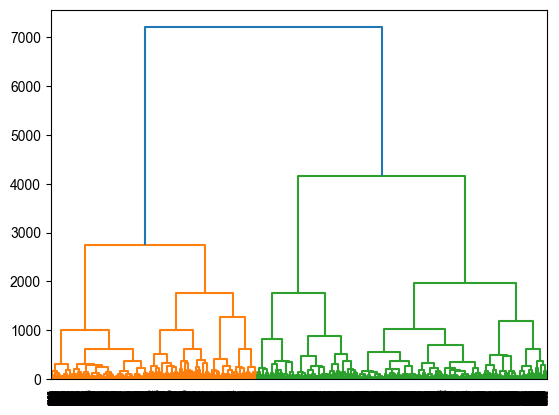

In [104]:
# Cluster the TFs
Z = linkage(cor_df, 'ward')
cluster_order = np.array([int(item) for item in dendrogram(Z)["ivl"]])
cluster_order = pd.Series(list(range(cor_df.shape[0])),
    index=cor_df.index.values[cluster_order])
gene_clusters = pd.Series(fcluster(Z, 4, depth=10), 
    index=cor_df.index.values[cluster_order])

In [105]:
# Group the seqlets using MarkerFinder
from pyInfinityFlow.InfinityFlow_Utilities import marker_finder

r_df, p_df = marker_finder(\
    cor_df.loc[gene_clusters.index.values], 
    gene_clusters)

marker_df = pd.DataFrame({\
        "seqlet_idx": r_df.index.values,
        "r": r_df.max(axis=1),
        "gene_cluster": r_df.idxmax(axis=1)},
    index=r_df.index.values).sort_values(by=["gene_cluster", "r"], 
        ascending=[True, False])

In [106]:
# Save the gene clusters
gene_clusters.loc[cluster_order.index.values].to_csv(\
    "output/chrombpnet/modisco_merged_results/fold_0/redo_extract_seqlets/WITH_ALL_GENES/"\
    "seqlet_to_gene_expression_correlation_gene_clusters.csv",
    header=False, index=True)
# Save the markerfinder seqlet clusters
marker_df.to_csv(\
    "output/chrombpnet/modisco_merged_results/fold_0/redo_extract_seqlets/WITH_ALL_GENES/"\
    "seqlet_to_gene_expression_correlation_seqlet_markerfinder.csv",
    header=True, index=False)

: 